In [1]:
from pathlib import Path 
import torch
import pandas as pd 
import numpy as np 

import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path 

sns.set_style("whitegrid")
pd.set_option('display.max_rows', 500)
# set font size seaborn
sns.set_context("notebook", font_scale=1.25)

%load_ext autoreload
%autoreload 2
%matplotlib inline 

BUILDINGS_BENCH_PATH = os.environ.get('BUILDINGS_BENCH', '')
if BUILDINGS_BENCH_PATH == '':
    raise ValueError('BUILDINGS_BENCH environment variable not set')
else:
    assert '2.0.0' in BUILDINGS_BENCH_PATH, 'BUILDINGS_BENCH must point to buildings_bench v2.0.0'
BUILDINGS_BENCH_PATH = Path(BUILDINGS_BENCH_PATH)

### Merge `_last` and `_best` checkpoints

In [6]:
model_name = '../checkpoints/pemami/ResNet_bert_energyplus_comstock_keyvalue'
seeds = [1000, 1001, 1002]

In [7]:
models_last = [f'{model_name}_seed={seed}_last.pt' for seed in seeds]
models_best = [f'{model_name}_seed={seed}_best.pt' for seed in seeds]
models_merged = [f'{model_name}_seed={seed}_merged.pt' for seed in seeds]

for m1, m2, mout in zip(models_last, models_best, models_merged):
    
    all_ckpts = [ torch.load( Path(m1) )['model'], torch.load( Path(m2) )['model'] ]

    new_state_dict = {'model': {}}
    # for each parameter
    for k in all_ckpts[0].keys():
        agg= []
        # aggregate across all checkpoints
        for ckpt in all_ckpts:
            agg += [ckpt[k]]
        
        #print(agg)
        try:
            new_state_dict['model'][k] = torch.mean(torch.stack(agg,0), dim=0)
        except RuntimeError:
            if 'l_kernel' in k:
                new_state_dict['model'][k] = agg[0]
                print(k, agg)
        #print(new_state_dict['model'][k])

    torch.save(new_state_dict, Path(mout) )

### Figure 3

In [2]:
def horizontal_bar_plot(dataframe,
                  dataframe_to_average=None,
                  Ns=[], 
                  plot_name='',
                  column = 'model',
                  column_match = 'contains',
                  categories=['ssm_onehot', 'ssm_basic', 'ssm_medium', 'resnet_onehot', 'resnet_basic', 'lstm_onehot', 'lstm_basic', 'lgbm_onehot'],
                  aggregation='nrmse-per-run-hourly',
                  linestyles=[], labels=[]):
    """
    If dataframe_to_average is not None, take a weighted average
    """    
    colors = plt.cm.copper(np.linspace(0,1,len(categories)))
    
    if len(linestyles) == 0:
        linestyles = ['-' for _ in range(len(categories))]
    # average over seeds
    if len(categories) < 5:
        plt.figure(figsize=(9,5))
        y_values = np.arange(len(categories)) / len(categories)
    else:
        y_values = categories
    i = 0
    for cat,ls,c,lbl in zip(categories,linestyles,colors,labels):
        if column_match == 'contains':
            df = dataframe[dataframe[column].str.contains(cat)]
        elif column_match == 'exact':
            df = dataframe[dataframe[column] == cat]
        xs = [aggregation]

        if dataframe_to_average is None:
            ys = [np.mean(df[x]) for x in xs]
            errs = [np.std(df[x]) for x in xs]
            bias_err = np.mean(df['nmbe-per-run-hourly'])
        else:
            total_N = np.sum(Ns)
            if column_match == 'contains':
                df2 = dataframe_to_average[dataframe_to_average[column].str.contains(cat)]
            elif column_match == 'exact':
                df2 = dataframe_to_average[dataframe_to_average[column] == cat]
            ys, errs = [], []
            for x in xs:
                mean1 = np.mean(df[x])
                mean2 = np.mean(df2[x])
                ys += [ (Ns[0]/total_N)*mean1 + (Ns[1]/total_N)*mean2 ]
                errs += [
                    np.sqrt( ((Ns[0]-1)*np.var(df[x]) + (Ns[1]-1)*np.var(df2[x])) / (total_N-2) )
                ]
                bias_err = np.mean([ np.mean(df['nmbe-per-run-hourly']), np.mean(df2['nmbe-per-run-hourly']) ])
        # horizontal barplot
        # set bar width 
        if len(categories) < 5:
            bar_height = 0.2
        else:
            bar_height = 0.8
        plt.barh(y_values[i], ys, xerr=errs, label=lbl + f' ({bias_err:.3f})', height=bar_height,
                     linewidth=2, linestyle=ls, color=c, ecolor='black', capsize=5)
        for x,y,ste in zip(xs,ys,errs):
            #print(f'{cat} {x} {y:.4f} +/- {ste:.4f}, nmbe {bias_err:.4f}')
            print(f'{cat} {x}', f'{np.round(y,3):.3f}' + "{\\tiny{$\pm$ " + f'{np.round(ste,3):.3f}' + '}}')
            
        i += 1
    plt.yticks(ticks=y_values, labels=labels, rotation='horizontal')
    plt.xlabel('NRMSE')
    # remove extra space between horizontal bars
    plt.savefig(f'{plot_name}_{aggregation}_horizontal_barplot.pdf', bbox_inches='tight')
    plt.savefig(f'{plot_name}_{aggregation}_horizontal_barplot.png', bbox_inches='tight')
    
    plt.show()
    

SSM_bert_energyplus_comstock_medium nrmse-per-run-hourly 0.543{\tiny{$\pm$ 0.011}}
SSM_bert_energyplus_comstock_keyvalue nrmse-per-run-hourly 0.450{\tiny{$\pm$ 0.007}}
LSTM_bert_energyplus_comstock_keyvalue nrmse-per-run-hourly 0.439{\tiny{$\pm$ 0.037}}
ResNet_bert_energyplus_comstock_keyvalue nrmse-per-run-hourly 0.670{\tiny{$\pm$ 0.043}}


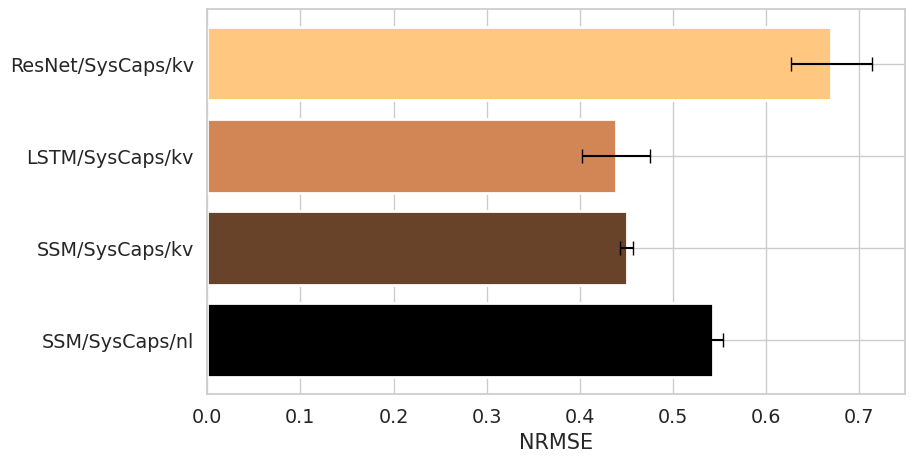

In [13]:
df = pd.read_csv('../results/neurips_rebuttal_bert.csv')
df1 = df[df.dataset == 'comstock_attribute_combos_seed=42.idx']
df2 = df[df.dataset =='comstock_buildings900k_test_seed=42.idx']
horizontal_bar_plot(df1, df2, Ns=[3, 3], # number seeds for each dataset
                plot_name='comstock_accuracy',
                categories=['SSM_bert_energyplus_comstock_medium',
                            'SSM_bert_energyplus_comstock_keyvalue',
                            'LSTM_bert_energyplus_comstock_keyvalue',
                            'ResNet_bert_energyplus_comstock_keyvalue'],
                aggregation='nrmse-per-run-hourly',
                labels=['SSM/SysCaps/nl', 'SSM/SysCaps/kv',  'LSTM/SysCaps/kv',  'ResNet/SysCaps/kv'])#, 'SSM/X'])

SSM_bert_energyplus_comstock_medium nrmse-stock-annual 0.035{\tiny{$\pm$ 0.005}}
SSM_bert_energyplus_comstock_keyvalue nrmse-stock-annual 0.020{\tiny{$\pm$ 0.012}}
LSTM_bert_energyplus_comstock_keyvalue nrmse-stock-annual 0.022{\tiny{$\pm$ 0.011}}
ResNet_bert_energyplus_comstock_keyvalue nrmse-stock-annual 0.049{\tiny{$\pm$ 0.015}}


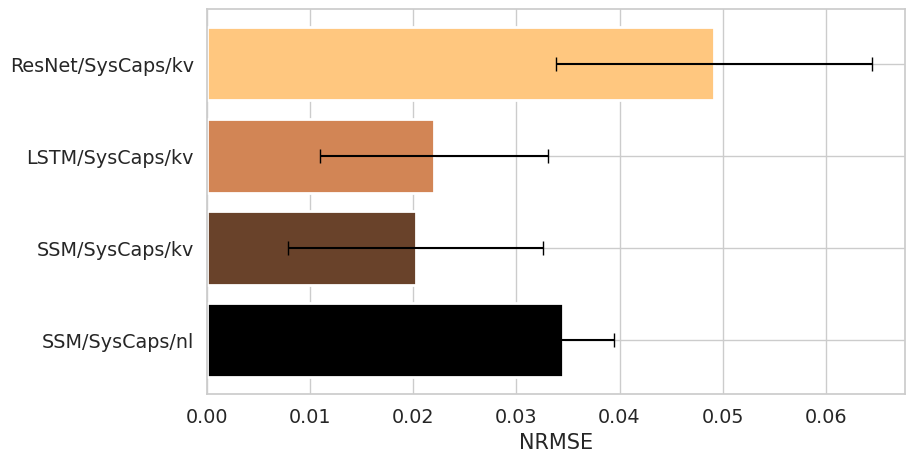

In [14]:
df = pd.read_csv('../results/neurips_rebuttal_bert.csv')
df1 = df[df.dataset == 'comstock_attribute_combos_seed=42.idx']
df2 = df[df.dataset =='comstock_buildings900k_test_seed=42.idx']
horizontal_bar_plot(df1, df2, Ns=[3, 3], # number seeds for each dataset
                plot_name='comstock_accuracy',
                categories=['SSM_bert_energyplus_comstock_medium',
                            'SSM_bert_energyplus_comstock_keyvalue',
                            'LSTM_bert_energyplus_comstock_keyvalue',
                            'ResNet_bert_energyplus_comstock_keyvalue'],
                aggregation='nrmse-stock-annual',
                labels=['SSM/SysCaps/nl', 'SSM/SysCaps/kv',  'LSTM/SysCaps/kv',  'ResNet/SysCaps/kv'])#, 'SSM/X'])

SSM_bert_energyplus_comstock_medium nrmse-per-run-hourly 0.543{\tiny{$\pm$ 0.011}}
SSM_bert_energyplus_comstock_keyvalue nrmse-per-run-hourly 0.450{\tiny{$\pm$ 0.007}}
ssm_onehot nrmse-per-run-hourly 0.450{\tiny{$\pm$ 0.019}}
LSTM_bert_energyplus_comstock_keyvalue nrmse-per-run-hourly 0.439{\tiny{$\pm$ 0.037}}
lstm_onehot nrmse-per-run-hourly 0.449{\tiny{$\pm$ 0.025}}
ResNet_bert_energyplus_comstock_keyvalue nrmse-per-run-hourly 0.670{\tiny{$\pm$ 0.043}}
resnet_onehot nrmse-per-run-hourly 0.634{\tiny{$\pm$ 0.009}}
lgbm_onehot nrmse-per-run-hourly 0.679{\tiny{$\pm$ 0.014}}
comstock_no nrmse-per-run-hourly 1.712{\tiny{$\pm$ 0.003}}


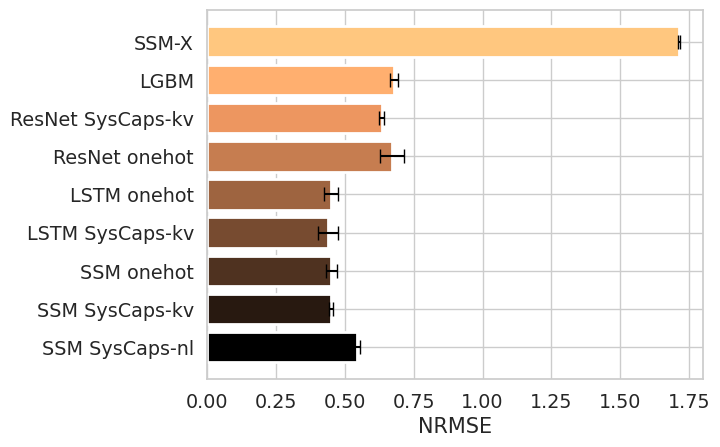

In [4]:
df_old = pd.read_csv('../results/comstock_accuracy.csv')
df_attribute_combos = df_old[df_old.dataset == 'comstock_attribute_combos_seed=42.idx']
df_buildings900k = df_old[df_old.dataset=='comstock_buildings900k_test_seed=42.idx']
horizontal_bar_plot(df_attribute_combos, df_buildings900k, Ns=[3, 3],
                plot_name='comstock_accuracy',
                categories=[
                    'SSM_bert_energyplus_comstock_medium',
                    'SSM_bert_energyplus_comstock_keyvalue',
                    'ssm_onehot',
                    'LSTM_bert_energyplus_comstock_keyvalue',
                    'lstm_onehot',
                    'ResNet_bert_energyplus_comstock_keyvalue',
                    'resnet_onehot', 
                    'lgbm_onehot',
                    'comstock_no'],
                aggregation='nrmse-per-run-hourly',
                #linestyles=['-', '--', '-', '--', '-', '--', '-'],
                labels=['SSM SysCaps-nl', 'SSM SysCaps-kv',  'SSM onehot', 'LSTM SysCaps-kv','LSTM onehot',  'ResNet onehot', 'ResNet SysCaps-kv',  'LGBM', 'SSM-X'])

SSM_bert_energyplus_comstock_medium nrmse-stock-annual 0.035{\tiny{$\pm$ 0.005}}
SSM_bert_energyplus_comstock_keyvalue nrmse-stock-annual 0.020{\tiny{$\pm$ 0.012}}
ssm_onehot nrmse-stock-annual 0.041{\tiny{$\pm$ 0.021}}
LSTM_bert_energyplus_comstock_keyvalue nrmse-stock-annual 0.022{\tiny{$\pm$ 0.011}}
lstm_onehot nrmse-stock-annual 0.045{\tiny{$\pm$ 0.024}}
ResNet_bert_energyplus_comstock_keyvalue nrmse-stock-annual 0.049{\tiny{$\pm$ 0.015}}
resnet_onehot nrmse-stock-annual 0.072{\tiny{$\pm$ 0.008}}
lgbm_onehot nrmse-stock-annual 0.094{\tiny{$\pm$ 0.003}}


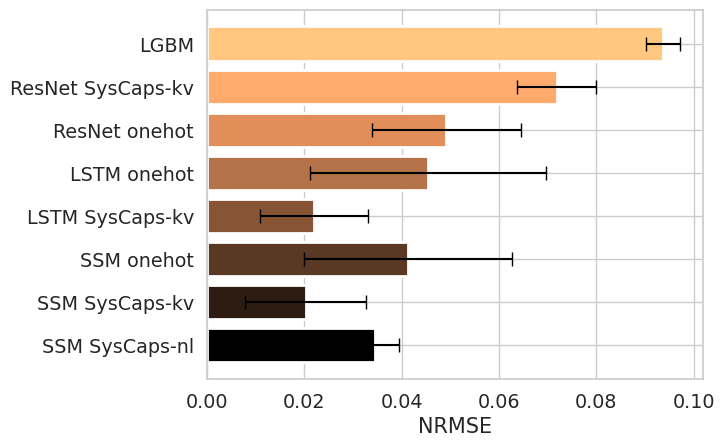

In [6]:
df_old = pd.read_csv('../results/comstock_accuracy.csv')
df_attribute_combos = df_old[df_old.dataset == 'comstock_attribute_combos_seed=42.idx']
df_buildings900k = df_old[df_old.dataset=='comstock_buildings900k_test_seed=42.idx']
horizontal_bar_plot(df_attribute_combos, df_buildings900k, Ns=[3, 3],
                plot_name='comstock_accuracy',
                categories=[
                    'SSM_bert_energyplus_comstock_medium',
                    'SSM_bert_energyplus_comstock_keyvalue',
                    'ssm_onehot',
                    'LSTM_bert_energyplus_comstock_keyvalue',
                    'lstm_onehot',
                    'ResNet_bert_energyplus_comstock_keyvalue',
                    'resnet_onehot', 
                    'lgbm_onehot'                    
                ],
                aggregation='nrmse-stock-annual',
                #linestyles=['-', '--', '-', '--', '-', '--', '-'],
                labels=['SSM SysCaps-nl', 'SSM SysCaps-kv',  'SSM onehot', 'LSTM SysCaps-kv','LSTM onehot',  'ResNet onehot', 'ResNet SysCaps-kv',  'LGBM'])

## Building Type Generalization

In [26]:
bt_df = pd.read_csv('../results/rebuttal_randomized_bt.csv')
bt_df_buildings900k = bt_df[bt_df.dataset == 'comstock_buildings900k_test_seed=42.idx']
bt_df_attribute_combos = bt_df[bt_df.dataset == 'comstock_attribute_combos_seed=42.idx']
Ns = [3,3]
total_N = np.sum(Ns)
building_types = {
        'FullServiceRestaurant': 'FineDiningRestaurant',
        'RetailStripmall': 'ShoppingCenter',
        'Warehouse': 'StorageFacility',
        'RetailStandalone': 'ConvenienceStore',
        'SmallOffice': 'Co-WorkingSpace',
        'PrimarySchool': 'ElementarySchool',
        'MediumOffice': 'Workplace',
        'SecondarySchool': 'HighSchool',
        'Outpatient': 'MedicalClinic',
        'QuickServiceRestaurant': 'FastFoodRestaurant',
        'LargeOffice': 'OfficeTower',
        'LargeHotel': 'Five-Star Hotel',
        'SmallHotel': 'Motel',
        'Hospital': 'HealthcareFacility'
}
table_results = pd.DataFrame(columns=['bldg type', 'synonym', 'synonym caption nrmse', 'missing', 'randomized bt nrmse'])
for bldg_type in building_types.keys():
    row = {}
    row['bldg type'] = bldg_type
    row['synonym'] = building_types[bldg_type]
    for row_n,c in zip([ 'randomized bt nrmse', 'synonym caption nrmse', 'missing'], ['medium_generalization_building_type_randomized', 'medium_generalization_building_type', 'medium_missing_building_type']):
        data1 = bt_df_buildings900k[bt_df_buildings900k.caption == c]
        data2 = bt_df_attribute_combos[bt_df_attribute_combos.caption == c]
        orig1 = bt_df_buildings900k[bt_df_buildings900k.caption == 'medium']
        orig2 = bt_df_attribute_combos[bt_df_attribute_combos.caption == 'medium']
        x = f'nrmse-per-run-hourly-{bldg_type}'
        if not np.isnan(data2[x]).any():
            mean1 = np.mean(data1[x].values - orig1[x].values)
            mean2 = np.mean(data2[x].values - orig2[x].values)
            mean = (Ns[0]/total_N)*mean1 + (Ns[1]/total_N)*mean2
            std = np.sqrt( ((Ns[0]-1)*np.var(data1[x].values - orig1[x].values) + (Ns[1]-1)*np.var(data2[x].values - orig2[x].values)) / (total_N-2) )
        else:
            mean = np.mean(data1[x].values - orig1[x].values)
            std = np.std(data1[x].values - orig1[x].values)
        row[row_n] = f'{np.round(mean,2):.2f}' + "{\\tiny{$\pm$ " + f'{np.round(std,2):.2f}' + '}}'
        
    # append row to DataFrame
    table_results = pd.concat([table_results, pd.DataFrame([row])], ignore_index=True)
print(table_results.to_latex(index=False))


\begin{tabular}{lllll}
\toprule
bldg type & synonym & synonym caption nrmse & missing & randomized bt nrmse \\
\midrule
FullServiceRestaurant & FineDiningRestaurant & 0.52{\tiny{$\pm$ 0.05}} & 0.93{\tiny{$\pm$ 0.01}} & 1.17{\tiny{$\pm$ 0.07}} \\
RetailStripmall & ShoppingCenter & 0.01{\tiny{$\pm$ 0.00}} & -0.01{\tiny{$\pm$ 0.00}} & 0.28{\tiny{$\pm$ 0.04}} \\
Warehouse & StorageFacility & 0.35{\tiny{$\pm$ 0.30}} & 0.56{\tiny{$\pm$ 0.28}} & 4.02{\tiny{$\pm$ 0.32}} \\
RetailStandalone & ConvenienceStore & 0.00{\tiny{$\pm$ 0.01}} & 0.28{\tiny{$\pm$ 0.03}} & 0.40{\tiny{$\pm$ 0.03}} \\
SmallOffice & Co-WorkingSpace & 0.03{\tiny{$\pm$ 0.01}} & 0.02{\tiny{$\pm$ 0.02}} & 1.95{\tiny{$\pm$ 0.30}} \\
PrimarySchool & ElementarySchool & -0.00{\tiny{$\pm$ 0.01}} & 0.34{\tiny{$\pm$ 0.04}} & 0.52{\tiny{$\pm$ 0.17}} \\
MediumOffice & Workplace & 0.08{\tiny{$\pm$ 0.02}} & -0.00{\tiny{$\pm$ 0.02}} & 0.91{\tiny{$\pm$ 0.11}} \\
SecondarySchool & HighSchool & -0.01{\tiny{$\pm$ 0.04}} & 0.48{\tiny{$\pm$ 0.07}

## Classifier

In [25]:
df_classifier = pd.read_csv('../results/classifier_results.csv', index_col=None)

# print mean attribute accuracy per row
for name in ['short captions', 'medium captions', 'long captions']:
    df_ = df_classifier[df_classifier['Name'] == name]
    # collect all values for each attribute
    vals = []
    for x in df_.columns:
        if 'test/comstock_attribute_combos_seed=42.idx/attribute_accuracy' in x:
            vals.append(df_[x])
        elif 'test/comstock_buildings900k_test_seed=42.idx/attribute_accuracy' in x:
            import pdb; pdb.set_trace()
            
            vals.append(df_[x])
    
    print(f'{name} mean test/attribute_accuracy {np.mean(vals)}')
    

results_by_attribute = {}
for c in df_classifier.columns:
    if 'test/comstock_attribute_combos_seed=42.idx/attribute_accuracy' in c or \
        'test/comstock_buildings900k_test_seed=42.idx/attribute_accuracy' in c:
        att_name = c.split('/')[-1]
        if att_name not in results_by_attribute:
            results_by_attribute[att_name] = [df_classifier[c]]
        else:
            results_by_attribute[att_name].append(df_classifier[c])
            
for k,v in results_by_attribute.items():
    print(f'{k} {np.mean(v)}')

> /tmp/ipykernel_2302443/3861733916.py(14)<module>()
     12             import pdb; pdb.set_trace()
     13 
---> 14             vals.append(df_[x])
     15 
     16     print(f'{name} mean test/attribute_accuracy {np.mean(vals)}')

*** SyntaxError: invalid syntax
'test/comstock_buildings900k_test_seed=42.idx/attribute_accuracy/in.building_subtype'
1    91.999996
Name: test/comstock_buildings900k_test_seed=42.idx/attribute_accuracy/in.building_subtype, dtype: float64
1    91.999996
Name: test/comstock_buildings900k_test_seed=42.idx/attribute_accuracy/in.building_subtype, dtype: float64
1    91.999996
Name: test/comstock_attribute_combos_seed=42.idx/attribute_accuracy/in.building_subtype, dtype: float64
